In [1]:
# To enable autcomplete
%config IPCompleter.greedy=True

In [2]:
import datetime # to get current date and time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from twitterscraper import query_tweets_from_user

%matplotlib inline

# Raw state csv pulled from New York Times Github
url1 = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states= pd.read_csv(url1)

# Raw county csv pulled from New York Times Github
url2 = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
county = pd.read_csv(url2)

INFO: {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; rv:2.2) Gecko/20110201'}


In [3]:
states

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
3254,2020-04-30,Virginia,51,15846,552
3255,2020-04-30,Washington,53,14696,822
3256,2020-04-30,West Virginia,54,1125,44
3257,2020-04-30,Wisconsin,55,6854,316


In [4]:
# Isolate state data for New Jersey

# loc isolates data based on labels, save as new dataframe
nj = states.loc[states['state'] == "New Jersey"]
nj

,date,state,fips,cases,deaths
292,2020-03-04,New Jersey,34,1,0
312,2020-03-05,New Jersey,34,2,0
337,2020-03-06,New Jersey,34,4,0
368,2020-03-07,New Jersey,34,4,0
403,2020-03-08,New Jersey,34,6,0
439,2020-03-09,New Jersey,34,11,0
477,2020-03-10,New Jersey,34,15,1
519,2020-03-11,New Jersey,34,23,1
566,2020-03-12,New Jersey,34,29,1
616,2020-03-13,New Jersey,34,50,1


In [5]:
# Determine days of outbreak

totalDays = nj.shape[0] # get number of rows containing NJ
njLength = np.linspace(1,totalDays,totalDays)
njCases = np.array(nj["cases"])

In [6]:
# Get current date and time

# now method returns date and time
now = datetime.datetime.now()
# I returns hour in 12 hour format, p returns AM or PM based on time
dateAndTime = now.strftime("%m/%d/%Y %I:%M %p")

In [7]:
# Get last date of available data
recentDate = county.at[county.index[-1], 'date']

# Isolate NJ Counties for given date
njCountyList = county[(county['state'] == "New Jersey") & (county["date"] == recentDate)]

njCountyList

,date,county,state,fips,cases,deaths
102712,2020-04-30,Atlantic,New Jersey,34001.0,964,41
102713,2020-04-30,Bergen,New Jersey,34003.0,15610,1136
102714,2020-04-30,Burlington,New Jersey,34005.0,2690,130
102715,2020-04-30,Camden,New Jersey,34007.0,3519,147
102716,2020-04-30,Cape May,New Jersey,34009.0,323,22
102717,2020-04-30,Cumberland,New Jersey,34011.0,723,12
102718,2020-04-30,Essex,New Jersey,34013.0,13682,1186
102719,2020-04-30,Gloucester,New Jersey,34015.0,1251,46
102720,2020-04-30,Hudson,New Jersey,34017.0,14916,798
102721,2020-04-30,Hunterdon,New Jersey,34019.0,603,29


last updated at: 05/01/2020 07:56 PM


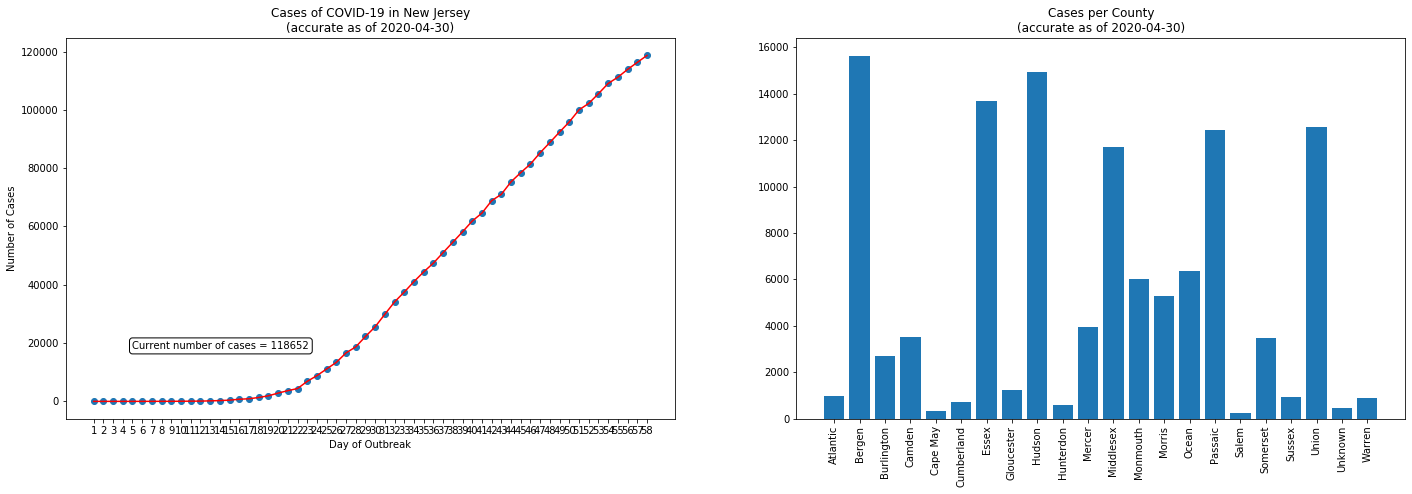

In [22]:

# Create figure object with two subplots oriented horizontally

figure, (sc, ba) = plt.subplots(1,2, figsize=(24,7))

# Plot NJ cases vs time

sc.scatter(njLength, njCases)
sc.plot(njLength, njCases, color = 'r')
sTitle = "Cases of COVID-19 in New Jersey\n(accurate as of " + recentDate + ")"
sc.set_title(sTitle)
sc.set_xlabel("Day of Outbreak")
sc.set_ylabel("Number of Cases")

# adjust ticks to show all days
xticks = np.arange(1,njLength.max()+1,1)
sc.set_xticks(xticks); # semicolon suppresses output of this function

# Create box label
labelText = "Current number of cases = " + str(njCases.max())
box = dict(boxstyle = 'round', facecolor = 'white')
sc.text(5, 18000,labelText,bbox=box);

# Plot cases per county

ba.bar(njCountyList['county'], njCountyList['cases'] )

bTitle = "Cases per County\n(accurate as of " + recentDate + ")"
ba.set_xticklabels(njCountyList['county'], rotation = 90);
ba.set_title(bTitle);

print("last updated at: {}".format(dateAndTime))

last updated at: 05/01/2020 07:56 PM


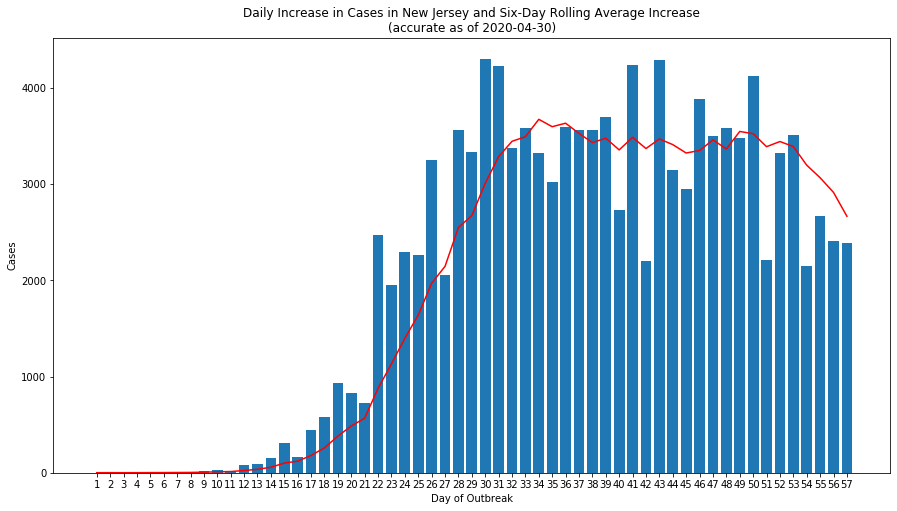

In [23]:
# Create list of the increase in cases between each day and rate of change

newCases = []

for i in range(0, len(njCases)-1):
    newCases.append(njCases[i+1]-njCases[i]) # subtract current number of cases by previous number

newCases = np.array(newCases) # convert case number list to array

numDaysExceptLast = len(njLength) # need to remove last day from list

newCaseDays = np.arange(1, numDaysExceptLast) # convert day list to array

ticks = np.arange(1,newCaseDays.max()+1,1); #generate x ticks

fig= plt.figure(figsize=(15,8)) # create figure

axes = fig.add_subplot() # automatically adds axis (graph) in default position
axes.bar(newCaseDays, newCases.transpose())
axes.set_title("Daily Increase in Cases in New Jersey and Six-Day Rolling Average Increase\n(accurate as of "
               + recentDate + ")");
axes.set_xticks(ticks);
axes.set_xlabel("Day of Outbreak");
axes.set_ylabel("Cases");
print("last updated at: {}".format(dateAndTime))

'''
Adding line tracing 6 day rolling average increase in cases

Because data can be unreliable at any given day, a rolling average allows for 
visualization of trends over a longer period of time, which is more reliable.

At each day in the tracker, the mean is taken of the daily increases over the previous 6 days. 
For days 1-6, there are not 6 days worth of data, so the average is taken with all days up until that point.
After day 6, the starting variable increases by 1 to trail 6 days behind the current day's data, leaving 6 days in
between to calculate the average.
'''
meanCaseIncrease = []

sixDayStart = 0
for i in range(len(newCases)):
    if i > 6: # trail by 6 days once 6 days of data are available. Change number to alter number of days for average
        sixDayStart+=1
    # mean of previous 6 days, i+1 to avoid taking mean of empty space after last day of data
    meanCaseIncrease.append(np.mean(newCases[sixDayStart:i+1])); 
    
plt.plot(newCaseDays, meanCaseIncrease, color = 'r');

COVID-19 Hospitalizations in New Jersey:<br>Unlike case numbers, there is no direct source for all of the hospitalizations in New Jersey. However, the Governor of New Jersey started reporting hospitalizations almost every day (with some exceptions) from April 9th on his Twitter account, @GovMurphy. While the data from this account is incomplete, it is the only place reporting these values. The following code scrapes Twitter for the governor's tweets relating to hospitalization rates, parses each tweet for the correct number of hospitalizations, and then plots the values.

In [10]:
'''
The following lines search for tweets by the query in the quotes. This was used in previous versions of this script but has
been replaced by searching directly by username.

# Create Date Objects for start and end of data
startDate = datetime.date(2020, 4, 8)
endDate = datetime.date.today() + datetime.timedelta(days=1) # have to use tomorrow's date to include tweets from today
print(startDate)
print(endDate)
limit = 10000 # max number of tweets that will be grabbed
lang = 'english'
#username = GovMurphy
tweets = query_tweets("Phil Murphy", begindate = startDate, enddate = endDate, limit = limit, lang = lang)
'''
# scrape all tweets from this user
tweet = query_tweets_from_user("GovMurphy")

INFO: Scraping tweets from https://twitter.com/GovMurphy
INFO: Using proxy 103.224.185.20:56207
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1256270924548104199&reset_error_state=false
INFO: Using proxy 37.221.204.206:47424
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1256222041142894592&reset_error_state=false
INFO: Using proxy 103.216.82.213:6666
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255945394376396800&reset_error_state=false
INFO: Using proxy 45.165.131.12:8080
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1255863542407999489&reset_error_state=false
INFO: Using pr

INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1249330404714315776&reset_error_state=false
INFO: Using proxy 102.164.199.76:37491
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1249025806640218113&reset_error_state=false
INFO: Using proxy 41.254.44.241:53283
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1248960697242980355&reset_error_state=false
INFO: Using proxy 170.80.64.94:51706
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/timeline/tweets?include_available_features=1&include_entities=1&max_position=1248623999203946496&reset_error_state=false
INFO: Using proxy 93.88.216.51:46627
INFO: Scraping tweets from https://twitter.com/i/profiles/show/GovMurphy/

In [11]:
# convert tweet data to pandas dataframe
tweetData = pd.DataFrame(t.__dict__ for t in tweet)
tweetData

,screen_name,username,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,text,text_html,links,...,has_media,img_urls,video_url,likes,retweets,replies,is_replied,is_reply_to,parent_tweet_id,reply_to_users
0,GovMurphy,Governor Phil Murphy,948946378939609089,1256355987180617737,/GovMurphy/status/1256355987180617737,2020-05-01 22:53:03,1588373583,"Today, I signed Executive Order 135, allowing ...","<p class=""TweetTextSize TweetTextSize--normal ...",[https://nj.gov/governor/news/news/562020/appr...,...,True,[https://pbs.twimg.com/media/EW94wSPXYAYAPFe.jpg],,191,32,78,True,False,,[]
1,KellyannePolls,Kellyanne Conway,471672239,1256271364102782976,/KellyannePolls/status/1256271364102782976,2020-05-01 17:16:48,1588353408,Thanks to @GovMurphy & team for putting politi...,"<p class=""TweetTextSize TweetTextSize--normal ...",[https://twitter.com/GovMurphy/status/12559670...,...,False,[],,3458,800,291,True,False,,[]
2,FirstLadyNJ,Tammy Murphy,948951747912962048,1256313108114444289,/FirstLadyNJ/status/1256313108114444289,2020-05-01 20:02:40,1588363360,#AdventuresWithTammy\n\nLet’s start off the we...,"<p class=""TweetTextSize TweetTextSize--normal ...",[https://www.facebook.com/FirstLadyNJ/videos/2...,...,False,[],,44,5,50,True,False,,[]
3,NJGov,New Jersey,984819646082797568,1256284342181126146,/NJGov/status/1256284342181126146,2020-05-01 18:08:22,1588356502,STATE PARKS WILL REOPEN TOMORROW\n\nWhat you n...,"<p class=""TweetTextSize TweetTextSize--normal ...",[https://nj.gov/governor/news/news/562020/appr...,...,True,[https://pbs.twimg.com/media/EW8359TXgAQJVst.jpg],,752,243,68,True,False,,[]
4,GovMurphy,Governor Phil Murphy,948946378939609089,1256284136488271872,/GovMurphy/status/1256284136488271872,2020-05-01 18:07:33,1588356453,It’s this simple: Data determines dates.\n\nWh...,"<p class=""TweetTextSize TweetTextSize--normal ...",[],...,False,[],,765,95,278,True,False,,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,GovMurphy,Governor Phil Murphy,948946378939609089,1248581035224444929,/GovMurphy/status/1248581035224444929,2020-04-10 11:58:10,1586519890,May peace and love surround you and your famil...,"<p class=""TweetTextSize TweetTextSize--normal ...",[],...,True,[https://pbs.twimg.com/media/EVPZBTtU8AQBtaI.jpg],,1283,141,86,True,False,,[]
584,David041882,David,1241405808337915906,1248432133879685127,/David041882/status/1248432133879685127,2020-04-10 02:06:30,1586484390,@GovMurphy thank you so much for making it man...,"<p class=""TweetTextSize TweetTextSize--normal ...",[],...,False,[],,887,59,75,True,False,,[]
585,NJHigherEd,NJ Office of the Secretary of Higher Education,888455804218691590,1248395286956740611,/NJHigherEd/status/1248395286956740611,2020-04-09 23:40:05,1586475605,BREAKING: New Jersey’s public and private non-...,"<p class=""TweetTextSize TweetTextSize--normal ...",[https://twitter.com/usedgov/status/1248308332...,...,False,[],,161,65,28,True,False,,[]
586,vivek_murthy,Vivek Murthy,15552773,1248381093922762757,/vivek_murthy/status/1248381093922762757,2020-04-09 22:43:41,1586472221,Good to speak with you @GovMurphy - thank you ...,"<p class=""TweetTextSize TweetTextSize--normal ...",[https://twitter.com/GovMurphy/status/12483237...,...,False,[],,241,32,17,True,False,,[]


In [12]:
# Isolate all tweets from the GovMurphy account
tweetData = tweetData.loc[tweetData['username'] == "Governor Phil Murphy"]

# sort from earliest to most recent
tweetData = tweetData.sort_values(by=['timestamp_epochs']) # timestamp_epochs store number that increases with each tweet

# reset indices of all dataframe values after sorting
tweetText = tweetData.reset_index()

# isolate text from each tweet
tweetText = tweetText['text']
tweetText

0      Grateful to our child protection workers for t...
1      May peace and love surround you and your famil...
2      Join me live today at 10:30 AM for our daily b...
3      Holding a COVID-19 briefing. WATCH:https://www...
4      UPDATE: We’ve received 3,627 new positive #COV...
                             ...                        
488    To support health care and social workers acro...
489    When the parks open tomorrow, please act respo...
490    UPDATE: We have 2,651 new positive #COVID19 ca...
491    It’s this simple: Data determines dates.\n\nWh...
492    Today, I signed Executive Order 135, allowing ...
Name: text, Length: 493, dtype: object

In [13]:
def hospitalizationExtraction(dataframe, indexOfTweet):

    """
    Parses tweet for the number of hospitalized patients.
    
    Given a dataframe and the index of the tweet in the dataframe, finds where the word 'hospitalized'
    is in that tweet. Then it loops in reverse from that word to the beginning of the tweet until it finds a "word"
    which is a numerical value (the closest number before "hospitalizations" will be the probably be number of 
    hospitalized people, since that is how the sentences are written).
    However, if the first numerical characters are not the correct number, it will keep looking until it finds it.
    It then stores each character of the number in a list, then joins to string, then returns as int
    """
    
    wordsInTweet = dataframe[indexOfTweet].split() # split tweet into list of words
   
    # find index of "hospitalized", trying different splits with punctuation
    
    try:
        hospFound = wordsInTweet.index("hospitalized") # find 'hospitalized'
    except ValueError:
        try: 
            hospFound = wordsInTweet.index("hospitalized.") # find 'hospitalized.''
        except ValueError:
            try: 
                hospFound = wordsInTweet.index("hospitalized,") # find 'hospitalized.' 
            except ValueError:
                try: 
                    hospFound = wordsInTweet.index("hospitals.") # find 'hospitals.' 
                except:
                    return
    
    # loop from "hospitalizations" to the beginning of the list until the correct number is found

    digits = [] # holds list of all digits in the number 
    
    for word in range(hospFound,-1,-1): # loop through words (from -1 to include 0)
        
        for char in wordsInTweet[word]: 
            
            if char.isdigit() or char == "0": 
                digits.append(char)
            elif char == ":": # prevents times in XX:XX format from being included
                digits = []
          
        # if the number has 3 or more digits, it is most likely correct, so break loop
        if len(digits) > 3: 
            break
        # if the number is 2 digits or less, it is probably wrong so disregard these and continue loop
        else: 
            digits = []

    number = ""
    try:
        number = int(number.join(digits)) # combine digits into one string and convert to int
        return number
    except:
        return None # if the tweet is not in the proper format (no valid numbers or otherwise), return none

hospitalizationExtraction(tweetText,5) # test


7570

In [14]:
# generate list of rows from dataframe, tells how many tweets there are to search
hospDayCount = [i for i in range(tweetData.shape[0])]

# return hospitalization numbers from all tweets
hospitalized = [hospitalizationExtraction(tweetText,i) for i in hospDayCount]


# remove none values from invalid tweets
hospitalized = [i for i in hospitalized if i != None]

print(hospitalized)

# adjust count to only include valid tweets
hospDayCount = [i for i in range(1, len(hospitalized)+1)]


print(hospDayCount)

[7570, 7618, 7781, 8270, 8224, 8011, 7718, 6986, 7594, 7210, 7240, 6847, 6722, 6573, 6407, 6137, 5972]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


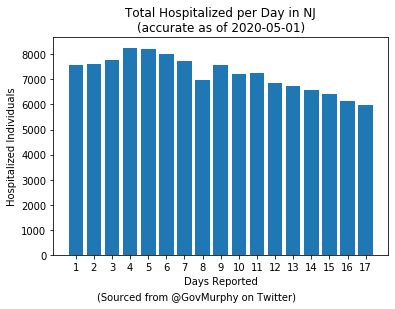

In [21]:
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(hospDayCount,hospitalized)
ax.set_title("Total Hospitalized per Day in NJ\n(accurate as of {})".format(datetime.date.today()))
ax.set_ylabel('Hospitalized Individuals')
ax.set_xlabel('Days Reported')
ax.set_xticks(hospDayCount);
ax.text(2.15,-1800,"(Sourced from @GovMurphy on Twitter)");